In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

customers = pd.read_csv('/content/drive/My Drive/Zeotap/Customers.csv')
products = pd.read_csv('/content/drive/My Drive/Zeotap/Products.csv')
transactions = pd.read_csv('/content/drive/My Drive/Zeotap/Transactions.csv')

Mounted at /content/drive


In [43]:
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')
merged_data = pd.merge(merged_data, products, on='ProductID', how='left')

In [44]:
customer_summary = merged_data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_order_value=('TotalValue', 'mean')
).reset_index()

df = pd.merge(customer_summary, customers, on='CustomerID', how='left')

In [45]:
df.head()

,CustomerID,total_spend,num_transactions,avg_order_value,CustomerName,Region,SignupDate
0,C0001,3354.52,5,670.904,Lawrence Carroll,South America,2022-07-10
1,C0002,1862.74,4,465.685,Elizabeth Lutz,Asia,2022-02-13
2,C0003,2725.38,4,681.345,Michael Rivera,South America,2024-03-07
3,C0004,5354.88,8,669.360,Kathleen Rodriguez,South America,2022-10-09
4,C0005,2034.24,3,678.080,Laura Weber,Asia,2022-08-15


In [46]:
df.columns

Index(['CustomerID', 'total_spend', 'num_transactions', 'avg_order_value',
       'CustomerName', 'Region', 'SignupDate'],
      dtype='object')

In [47]:
df.dtypes

,0
CustomerID,object
total_spend,float64
num_transactions,int64
avg_order_value,float64
CustomerName,object
Region,object
SignupDate,object


In [48]:
from datetime import datetime

df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['days_since_signup'] = (datetime.now() - df['SignupDate']).dt.days

In [49]:
from sklearn.preprocessing import LabelEncoder

le_region = LabelEncoder()
df['Region_encoded'] = le_region.fit_transform(df['Region'])

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['total_spend', 'num_transactions', 'avg_order_value', 'days_since_signup']] = scaler.fit_transform(
    df[['total_spend', 'num_transactions', 'avg_order_value', 'days_since_signup']])

In [51]:
features = df[['total_spend', 'num_transactions', 'avg_order_value', 'days_since_signup', 'Region_encoded']]

## K-Means Clustering

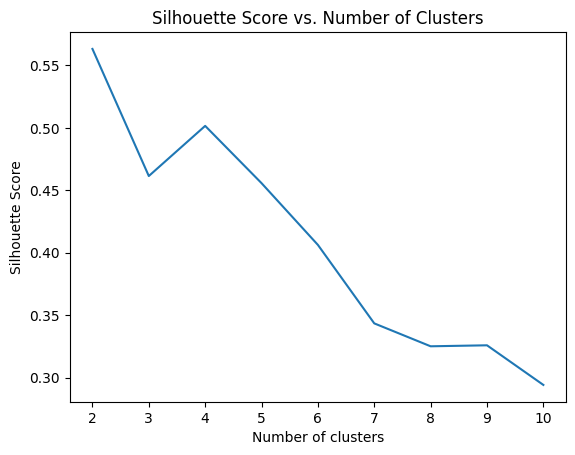

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [53]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

print(df[['CustomerID', 'Cluster']].head())

  CustomerID  Cluster
0      C0001        1
1      C0002        0
2      C0003        1
3      C0004        1
4      C0005        0


In [54]:
cluster_summary = df.groupby('Cluster').agg(
    total_spend=('total_spend', 'mean'),
    num_transactions=('num_transactions', 'mean'),
    avg_order_value=('avg_order_value', 'mean'),
    days_since_signup=('days_since_signup', 'mean')
).reset_index()

print(cluster_summary)

   Cluster  total_spend  num_transactions  avg_order_value  days_since_signup
0        0     0.311960          0.380851         0.499939           0.500338
1        1     0.326423          0.421905         0.476888           0.486666


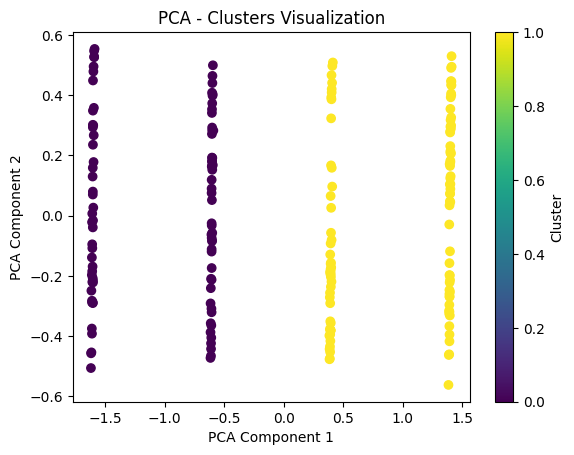

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA - Clusters Visualization')
plt.colorbar(label='Cluster')
plt.show()

In [56]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(features, df['Cluster'])
print(f'Davies-Bouldin Index for the clustering: {db_index}')

Davies-Bouldin Index for the clustering: 0.6544570887283161


In [42]:
c0_customers = df[df['Cluster'] == 0]

c1_customers = df[df['Cluster'] == 1]

c0_customers[['CustomerID', 'CustomerName', 'Cluster']].to_csv('/content/cluster_0_customers.csv', index=False)
c1_customers[['CustomerID', 'CustomerName', 'Cluster']].to_csv('/content/cluster_1_customers.csv', index=False)